In [3]:
import sys
sys.path.append('../')  # noga
import os
import library
import library.models_lib.band_specific_ecog
import library.models_lib.common
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import scipy
import scipy.io
import scipy.signal
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

from torch.autograd import Variable
import torch, torch.nn as nn
import torch.nn.functional as F
import matplotlib.image as mpimg

import scipy
import sklearn
import sklearn.metrics
import math

import mne

import numpy as np
import scipy
import scipy.signal
import random
import scipy
import math
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import pandas
import numpy as np

from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler

import math

import sklearn
import sklearn.metrics

import matplotlib
import matplotlib.pyplot as plt

import copy

import scipy
import scipy.signal



from IPython.display import display, clear_output

def downsample(X, Y, frequency, x_times):
    assert x_times in range(13)
    X = scipy.signal.decimate(X, x_times, axis=0)
    Y = scipy.signal.decimate(Y, x_times, axis=0)
    return X, Y, frequency / x_times


def high_pass_filtering(X, frequency, cutoff_frequency):
    b, a = scipy.signal.butter(3, cutoff_frequency * 1.0 / (frequency * 1.0 / 2), 'high')
    for i in range(X.shape[1]):
        X[:, i] = scipy.signal.filtfilt(b, a, X[:, i])
    return X


def norch_filtering(X, Y, frequency, remove_frequency):
    QUALITY = 30
    b, a = scipy.signal.iirnotch(remove_frequency * 1.0 / (frequency * 1.0 / 2), QUALITY)
    for i in range(X.shape[1]):
        X[:, i] = scipy.signal.filtfilt(b, a, X[:, i])
    return X, Y, frequency


def data_generator(X, Y, batch_size, shuffle=True, infinite=True):
    assert len(X)==len(Y) or len(Y)==0
    total_lag = lag_backward + lag_forward
    all_batches = math.ceil((X.shape[0] )/batch_size)
    samples_in_last_batch = (X.shape[0]) % batch_size
    batch = 0
    random_core = np.arange(0, X.shape[0])
    while True:
        if shuffle:
            np.random.shuffle(random_core)
        for batch in range(all_batches):       
            batch_start = batch * batch_size
            batch_end = (batch + 1)*batch_size
            if batch_end >= len(random_core):
                batch_end = None
            batch_samples = random_core[batch_start : batch_end]

            batch_x = X[[batch_samples]]
            #batch_x = np.swapaxes(batch_x, 1, 2)

            if len(Y) > 0:
                batch_y = Y[[batch_samples]] 
                yield (batch_x, batch_y)
            else:
                yield batch_x
        
        if not infinite:
            break

In [4]:
DATA_FOLDER = "/home/amplifier/common/gurasog/Data_for_Artur"
sorted_filenames = sorted(os.listdir(DATA_FOLDER))

FREQUENCY = 250
CHANNELS_COUNT = 30


MARK_TO_STATUS = {
    "SG01": {
        4: 'right_hand',
        5: 'pause',
        6: 'rest',
        7: 'right_leg',
        8: 'left_leg',
        9: 'left_hand'
    },
    "SG02": {
        1: 'protocol',
        2: 'rest',
        3: 'pause',
        4: 'left_leg',
        5: 'right_leg',
        6: 'left_hand',
        7: 'right_hand',
    },
    "SG03": {
        1: 'left_hand',
        2: 'pause',
        3: 'rest',
        5: 'left_leg',
        6: 'right_leg',
        7: 'right_hand',
    },
    "SG04": {
        2: 'right_hand',
        3: 'pause',
        4: 'left_leg',
        5: 'left_hand',
        6: 'rest',
        7: 'right_leg',
    },
    "SG05": {
        2: 'left_hand',
        3: 'pause',
        4: 'right_hand',
        5: 'rest',
        6: 'right_leg',
        7: 'left_leg',
    },
    "SG06": {
        1: 'rest',
        2: 'pause',
        3: 'left_hand',
        4: 'left_leg',
        5: 'right_leg',
        6: 'right_hand',
    }, 
}


STATUS_TO_LABEL = {
    'left_hand': 0,
    'right_hand': 1,
    'left_leg': 2,
    'right_leg': 3,
    'pause': -1,
    'protocol': -1,
    'rest': -1,
    'unknown': -1,
}


classes_examples_counter = {}

DATA_DICT = {}

def read_labels(labels_filename, statuses):
    labels = []
    with open(f"{DATA_FOLDER}/{labels_filename}") as input_file:
        for row in input_file:
            status = statuses.get(int(float(row.strip())), 'unknown')
            classes_examples_counter[status] = classes_examples_counter.get(status, 0) + 1
            labels.append(STATUS_TO_LABEL[status])
    return np.array(labels)

for data_filename, labels_filename in zip(sorted_filenames[::2], sorted_filenames[1::2]):
    print(data_filename, labels_filename)
    assert data_filename.split("_")[0] == labels_filename.split("_")[0]
    patient = data_filename.split("_")[0]
    
    data = mne.io.read_raw_fif(f"{DATA_FOLDER}/{data_filename}", preload=True, verbose=0).get_data().transpose()
    labels = read_labels(labels_filename, MARK_TO_STATUS[patient])

    assert labels.shape[0] == data.shape[0]
    assert data.shape[1] == CHANNELS_COUNT
    
    print(patient, f"{round(data.shape[0] / FREQUENCY / 60, 1)} minutes", f"{round(sum(labels != -1) / FREQUENCY / 60, 1)} real minutes")

    DATA_DICT[patient] = (data, labels)

print()
for label, count in classes_examples_counter.items():
    print(label, f"{round(count / FREQUENCY / 60, 1)} minutes")

SG01_motor_clean.fif SG01_motor_clean_marks.csv


<ipython-input-4-83e43efd7450>:91: RuntimeWarning: This filename (/home/amplifier/common/gurasog/Data_for_Artur/SG01_motor_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  data = mne.io.read_raw_fif(f"{DATA_FOLDER}/{data_filename}", preload=True, verbose=0).get_data().transpose()


SG01 7.3 minutes 3.2 real minutes
SG02_motor_clean.fif SG02_motor_clean_marks.csv


<ipython-input-4-83e43efd7450>:91: RuntimeWarning: This filename (/home/amplifier/common/gurasog/Data_for_Artur/SG02_motor_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  data = mne.io.read_raw_fif(f"{DATA_FOLDER}/{data_filename}", preload=True, verbose=0).get_data().transpose()


SG02 6.2 minutes 3.2 real minutes
SG03_motor_clean.fif SG03_motor_clean_marks.csv


<ipython-input-4-83e43efd7450>:91: RuntimeWarning: This filename (/home/amplifier/common/gurasog/Data_for_Artur/SG03_motor_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  data = mne.io.read_raw_fif(f"{DATA_FOLDER}/{data_filename}", preload=True, verbose=0).get_data().transpose()


SG03 9.3 minutes 4.0 real minutes
SG04_motor_clean.fif SG04_motor_clean_marks.csv


<ipython-input-4-83e43efd7450>:91: RuntimeWarning: This filename (/home/amplifier/common/gurasog/Data_for_Artur/SG04_motor_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  data = mne.io.read_raw_fif(f"{DATA_FOLDER}/{data_filename}", preload=True, verbose=0).get_data().transpose()


SG04 5.7 minutes 3.2 real minutes
SG05_motor_clean.fif SG05_motor_clean_marks.csv


<ipython-input-4-83e43efd7450>:91: RuntimeWarning: This filename (/home/amplifier/common/gurasog/Data_for_Artur/SG05_motor_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  data = mne.io.read_raw_fif(f"{DATA_FOLDER}/{data_filename}", preload=True, verbose=0).get_data().transpose()


SG05 5.7 minutes 3.2 real minutes
SG06_Motor_clean.fif SG06_Motor_clean_marks.csv


<ipython-input-4-83e43efd7450>:91: RuntimeWarning: This filename (/home/amplifier/common/gurasog/Data_for_Artur/SG06_Motor_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  data = mne.io.read_raw_fif(f"{DATA_FOLDER}/{data_filename}", preload=True, verbose=0).get_data().transpose()


SG06 5.7 minutes 3.2 real minutes

unknown 3.4 minutes
right_hand 4.0 minutes
pause 11.0 minutes
rest 5.3 minutes
right_leg 5.3 minutes
left_leg 5.3 minutes
left_hand 5.3 minutes
protocol 0.2 minutes


In [34]:
X_train.shape[0] / 250 / 60

9.952599999999999

In [5]:
def make_lag_3D(X_3D, lag_backward, lag_forward, decimate=1):
    # TODO: probably this code can be rewritten shorter
    assert decimate > 0
    assert lag_backward >=0
    assert lag_forward >=0

    output_samples = X_3D.shape[0] - lag_backward - lag_forward
    channels = X_3D.shape[1]
    feature_per_channel = X_3D.shape[2]
    # TODO: CHECK IF ITS VALID
    features_backward = int(lag_backward / decimate)
    features_forward = int(lag_forward / decimate)
    output_features = feature_per_channel * (1 + features_forward + features_backward)

    X_output_3D = np.zeros((output_samples, channels, output_features))
    feature_index = 0
    for time_shift in range(decimate, lag_backward + decimate, decimate):
        feature_slice = slice(feature_index, feature_index + feature_per_channel)
        X_output_3D[:, :, feature_slice] = X_3D[lag_backward - time_shift:-lag_forward - time_shift]
        feature_index += feature_per_channel

    feature_slice = slice(feature_index, feature_index + feature_per_channel)
    X_output_3D[:, :, feature_slice] = X_3D[lag_backward:-lag_forward if lag_forward > 0 else None]  # cetntral point
    feature_index += feature_per_channel

    for time_shift in range(decimate, lag_forward + decimate, decimate):
        feature_slice = slice(feature_index, feature_index + feature_per_channel)
        X_output_3D[:, :, feature_slice] = X_3D[lag_backward + time_shift:-lag_forward + time_shift if lag_forward - time_shift > 0 else None]
        feature_index += feature_per_channel
    assert feature_index == output_features
    return X_output_3D


LAG_BACKWARD = 250
LAG_FOREWARD = 250


def prepare_dataset(patients_indexes):
    X = []
    Y = []
    for patient in patients_indexes:
        x = None
        y = None
        if patient == 0:
            data = scipy.io.loadmat("//home/amplifier/common/pet67/ossadtchi-ml-test-bench/paper/1.mat")
            RIGHT_PAD = 1000
            x = data['data'][:30].transpose()[:-RIGHT_PAD]
            y = data['data'][30][:-RIGHT_PAD]
        else:
            x, y = DATA_DICT[f"SG0{patient}"]
        x = sklearn.preprocessing.scale(x)
        X.append(x)
        Y.append(y)

    X = np.concatenate(X, axis=0)
    Y = np.concatenate(Y, axis=0)


    X = make_lag_3D(X[:, :, None], LAG_BACKWARD, LAG_FOREWARD, 1)
    Y = Y[LAG_BACKWARD:-LAG_FOREWARD if LAG_FOREWARD > 0 else None]
    
    def all_equal(array):
        labels_set = set(array.tolist())
        return len(labels_set) == 1 and -1 not in labels_set


    good_indexes = []
    for i in range(LAG_BACKWARD + 1, Y.shape[0] - LAG_FOREWARD - 1):
        if all_equal(Y[i - LAG_BACKWARD - 1:i + LAG_FOREWARD + 1]):
            good_indexes.append(i)

    X = X[good_indexes]
    Y = Y[good_indexes]
    
    assert X.shape[0] == Y.shape[0], f"{X.shape[0]} != {Y.shape[0]}"
    
    return X, Y.reshape((-1, 1))


# patient 1: 0.5
# patient 2: 0.4
# patient 3: 0.4
# patient 4: 0.25
# patient 5: 0.4
# patient 6: 0.35

X_train, Y_train = prepare_dataset([2, 3, 5, 6])
X_test, Y_test = prepare_dataset([1])

# ntr = int(X_train.shape[0] * 0.5)

# X_test = X_train[ntr:]
# Y_test = Y_train[ntr:]

# X_train = X_train[:ntr]
# Y_train = Y_train[:ntr]



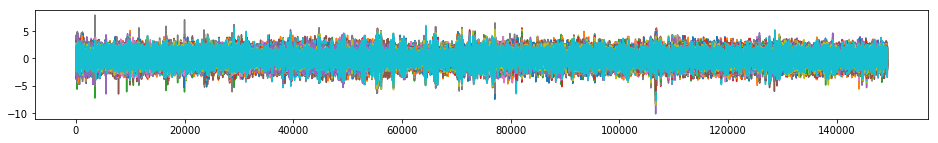

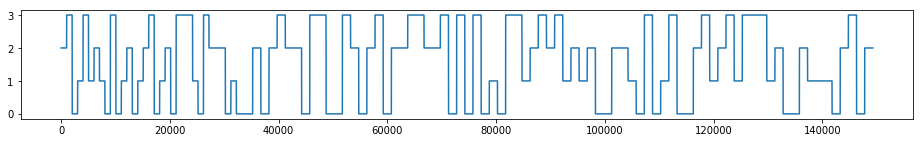

In [6]:
plt.figure(figsize=(16, 2))
plt.plot(X_train[:, :, 250])
plt.show()

plt.figure(figsize=(16, 2))
plt.plot(Y_train[:, :])
plt.show()

In [19]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class envelope_detector(nn.Module):
    def __init__(self, in_channels, channels_per_channel):
        super(self.__class__,self).__init__()
        self.FILTERING_SIZE = 100
        self.ENVELOPE_SIZE = 50
        self.CHANNELS_PER_CHANNEL = channels_per_channel
        self.OUTPUT_CHANNELS = self.CHANNELS_PER_CHANNEL * in_channels
        self.conv_filtering = nn.Conv1d(in_channels, self.OUTPUT_CHANNELS, bias=False, kernel_size=self.FILTERING_SIZE, groups=in_channels)
        self.conv_envelope = nn.Conv1d(self.OUTPUT_CHANNELS, self.OUTPUT_CHANNELS, kernel_size=self.ENVELOPE_SIZE, groups=self.OUTPUT_CHANNELS)
        self.conv_envelope.requires_grad = False
        self.pre_envelope_batchnorm = torch.nn.BatchNorm1d(self.OUTPUT_CHANNELS, affine=False) 
        self.relu = torch.nn.ReLU()
        self.intermidiate = None
        
        
    def forward(self, x):
        x = self.conv_filtering(x)
        x = self.pre_envelope_batchnorm(x)
        #x = self.relu(x)
        x = torch.abs(x)
        x = self.conv_envelope(x)
        return x


class simple_net(nn.Module):
    def __init__(self, in_channels, output_channels, lag_backward, lag_forward):
        super(self.__class__,self).__init__()
        self.ICA_CHANNELS = 5
        self.CHANNELS_PER_CHANNEL = 1

        self.total_input_channels = self.ICA_CHANNELS
        self.lag_backward = lag_backward
        self.lag_forward = lag_forward

        self.final_out_features = 180

        self.ica = nn.Conv1d(in_channels, self.ICA_CHANNELS, 1)

        self.detector = envelope_detector(self.total_input_channels, self.CHANNELS_PER_CHANNEL)
        self.features_batchnorm = torch.nn.BatchNorm1d(self.final_out_features, affine=False)
        self.unmixed_batchnorm = torch.nn.BatchNorm1d(self.total_input_channels, affine=False)

        self.wights_second = nn.Linear(self.final_out_features, output_channels)

    def forward(self, inputs):
        all_inputs = self.ica(inputs)
        self.fuck_channels = all_inputs.cpu().data.numpy()
        all_inputs = self.unmixed_batchnorm(all_inputs)

        detected_envelopes = self.detector(all_inputs)

        features  = detected_envelopes[:, :, ::10].contiguous()
        features = features.view(features.size(0), -1)
        features = self.features_batchnorm(features)
        self.pre_out = features.cpu().data.numpy()
        output = self.wights_second(features)
        return output


In [21]:
batch_size = 100
lag_backward = LAG_BACKWARD
lag_forward = LAG_FOREWARD

model = simple_net(X_train.shape[1], 5, lag_backward, lag_forward).cuda()


print("Trainable params: ",sum(p.numel() for p in model.parameters() if p.requires_grad))
print("Total params: ",sum(p.numel() for p in model.parameters() if p.requires_grad))
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)


loss_history_train = []
loss_history_test = []

Y_test_sliced = Y_test[lag_backward:]

pbar = tqdm_notebook()

def batch_iterator(X, Y, batch_size):
    assert X.shape[0] == Y.shape[0]
    length = len(X)
    for index in range(0, length, batch_size):
        current_slice = slice(index, min(index + batch_size, length))
        yield X[current_slice], Y[current_slice]
        
def random_iterator(X, Y, batch_size):
    assert X.shape[0] == Y.shape[0]
    length = len(X)
    while True:
        indexes = np.random.randint(0, length, batch_size)
        yield X[indexes], Y[indexes]

train_generator = random_iterator(X_train, Y_train, batch_size)
test_generator = random_iterator(X_test, Y_test, batch_size)


def process_batch(generator, is_train):
    if is_train:
        model.train()
    else:
        model.eval()

    x_batch, y_batch = next(generator)
    assert x_batch.shape[0] == y_batch.shape[0]
    assert y_batch.shape[1] == 1
    assert x_batch.shape[1] == 30
    x_batch = Variable(torch.FloatTensor(x_batch)).cuda()
    y_batch = Variable(torch.LongTensor(y_batch)).cuda()

    y_predicted = None
    if is_train:
        optimizer.zero_grad()
        y_predicted = model(x_batch)
        loss = loss_function(y_predicted, y_batch[:, 0])
        loss.backward()
        optimizer.step()
    else:
        y_predicted = model(x_batch)

    assert y_predicted.shape[0] == y_batch.shape[0]

    accuracy = np.mean(y_predicted.cpu().detach().numpy().argmax(axis=1) == y_batch.cpu().detach().numpy()[:, 0])

    if is_train:
        loss_history_train.append(accuracy)
    else:
        loss_history_test.append(accuracy)

while True:
    process_batch(train_generator, True)
    process_batch(test_generator, False)

    # tqdm
    pbar.update(1)
    eval_lag = min(1000, len(loss_history_train))
    pbar.set_postfix(train=np.mean(loss_history_train[-eval_lag:]), val=np.mean(loss_history_test[-eval_lag:]))



Trainable params:  1815
Total params:  1815


KeyboardInterrupt: 

In [22]:
batch_size = 100
lag_backward = LAG_BACKWARD
lag_forward = LAG_FOREWARD

model_name  = "multi_patient_net"

DUMP_DATA = True
if DUMP_DATA:
    import pickle
    with open('results_data/model_' + model_name, 'wb') as dump_file:
        pickle.dump({"model": model}, dump_file)


LOAD_MODEL = False
if LOAD_MODEL:
    import pickle
    with open('results_data/model_' + model_name, 'rb') as dump_file:
        model = pickle.load(dump_file)["model"]

In [27]:
X_unmixed = []
X_preout = []

Y_predicted = []
for x_batch, _ in tqdm_notebook(batch_iterator(X_test, Y_test, batch_size)):
    #### Train
    model.eval()

    x_batch = Variable(torch.FloatTensor(x_batch)).cuda()
    y_predicted = model(x_batch).cpu().data.numpy()
    assert x_batch.shape[0]==y_predicted.shape[0]
    Y_predicted.append(y_predicted)
    X_unmixed.append(model.fuck_channels)
    X_preout.append(model.pre_out)
    

X_unmixed = np.concatenate(X_unmixed, axis = 0)
X_unmixed = X_unmixed[:, :, -1]
X_preout = np.concatenate(X_preout, axis=0)
Y_predicted = np.concatenate(Y_predicted, axis = 0)

print("Correlation   val", np.mean(Y_predicted.argmax(axis=1) == Y_test[:, 0]))

Correlation   val 0.4708087339518321
